In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
# ^^^ pyforest auto-imports - don't write above this line


# Understand Customer Niches

In [3]:
df_last_year_updated = pd.read_csv('df_last_year_updated.csv')
df= df_last_year_updated

In [ ]:
# Calculate the overall average CLV across all customer types
average_clv = df['CLV'].mean()

# Calculate the CLV_Percentage for each entry in the DataFrame
df['CLV_Percentage'] = (df['CLV'] / average_clv) * 100

# Corrected order channel column names
order_channels = [
    'order_channel_at the store',
    'order_channel_by phone',
    'order_channel_during the visit of a sales rep',
    'order_channel_online',
    'order_channel_other'
]

# No need for assertion here as we have corrected the column names

# Determine the dominant order channel for each customer
df['main_order_channel'] = df[order_channels].idxmax(axis=1)

# Group by Customer_Type and aggregate the relevant metrics
customer_segmentation_CLV = df.groupby('Customer_Type').agg({
    'sales_net': 'sum',
    'quantity': 'sum',
    'client_id': 'nunique',
    'churn_probability': 'mean',
    'frequency': 'mean',
    'recency': 'mean',
    'potential_revenue_loss': 'mean',
    'CLV': 'mean',
    'CLV_Percentage': 'mean',
    'main_order_channel': lambda x: x.mode()[0]  # Most common order channel
}).reset_index()

# Define Value_Category based on the group's CLV_Percentage compared to a threshold
customer_segmentation_CLV['Value_Category'] = customer_segmentation_CLV['CLV_Percentage'].apply(
    lambda x: 'High Value' if x >= 10 else 'Low Value'
)

customer_segmentation_CLV = customer_segmentation_CLV[['Customer_Type', 'client_id', 'churn_probability',
                                                       'CLV_Percentage', 'frequency', 'recency',
                                                       'Value_Category']]
customer_segmentation_CLV


,Customer_Type,client_id,churn_probability,CLV_Percentage,frequency,recency,Value_Category
0,About To Sleep,6216,0.515622,3.089634,101.198450,73.226747,Low Value
1,At Risk,2637,0.982631,7.706203,476.652904,199.907349,Low Value
2,Can’t Lose Them,519,0.982360,0.029826,43.459270,229.406696,Low Value
3,Champions,18794,0.049210,129.874992,4027.781933,4.083478,High Value
4,Hibernating,12484,0.862214,0.180342,27.052433,195.682328,Low Value
5,Loyal Customers,22490,0.644173,13.377703,391.224633,13.552057,High Value
6,Potential Loyalist,7221,0.845757,14.663740,563.283504,51.902339,High Value
7,Promising,11890,0.009456,2.334798,73.134492,19.263231,Low Value
8,Recent Customers,6226,0.009479,2.278301,77.245421,6.984192,Low Value
9,Sporadic,18594,0.412488,0.496569,43.383096,75.646521,Low Value


In [ ]:
# Merging 'Value_Category' from 'customer_segmentation_CLV' into 'df'
df = df.merge(customer_segmentation_CLV[['Customer_Type', 'Value_Category']], on='Customer_Type', how='left')


In [ ]:
df.head()

,date_order,client_id,sales_net,quantity,product_price,order_channel_at the store,order_channel_by phone,order_channel_during the visit of a sales rep,order_channel_online,order_channel_other,...,lifespan,average_transaction_value,CLV,potential_revenue_loss,churn_probability,churned,CLV_Scaled,main_order_channel,CLV_Percentage,Value_Category
0,2019-08-13,6,60.858000,3,20.286000,0,1,0,0,0,...,266,142.825596,873806.993648,26214.209809,0.00868,0,-0.342834,order_channel_by phone,0.528722,Low Value
1,2019-07-31,6,41.538000,3,13.846000,1,0,0,0,0,...,266,142.825596,873806.993648,113594.909174,0.00868,0,-0.342834,order_channel_at the store,0.528722,Low Value
2,2019-07-31,6,63.673200,3,21.224400,1,0,0,0,0,...,266,142.825596,873806.993648,69904.559492,0.00868,0,-0.342834,order_channel_at the store,0.528722,Low Value
3,2019-07-31,6,370.653924,401,0.924324,1,0,0,0,0,...,266,142.825596,873806.993648,113594.909174,0.00868,0,-0.342834,order_channel_at the store,0.528722,Low Value
4,2019-07-25,6,60.858000,3,20.286000,0,1,0,0,0,...,266,142.825596,873806.993648,26214.209809,0.00868,0,-0.342834,order_channel_by phone,0.528722,Low Value


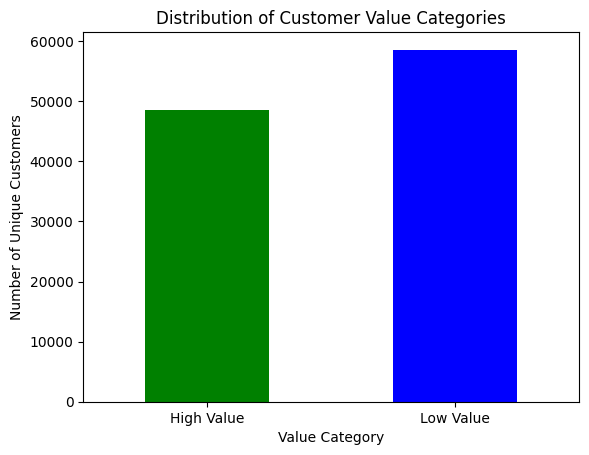

In [ ]:

# Calculate the count of unique 'client_id's for each 'Value_Category'
value_counts = df.groupby('Value_Category')['client_id'].nunique()

colors = ['green' if x == 'High Value' else 'blue' for x in value_counts.index]
value_counts.plot(kind='bar', color=colors)
plt.title('Distribution of Customer Value Categories')
plt.xlabel('Value Category')
plt.ylabel('Number of Unique Customers')
plt.xticks(rotation=0)
plt.show()



# Churn Alert

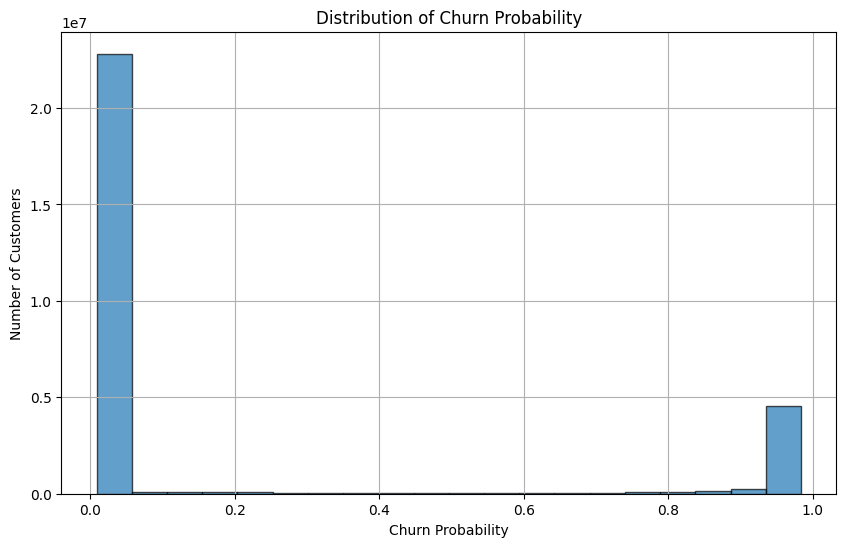

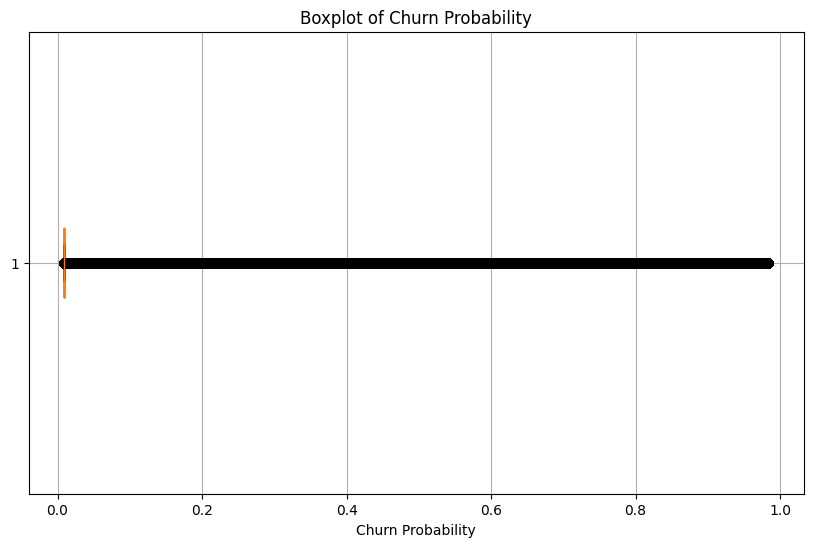

count    2.853452e+07
mean     1.876237e-01
std      3.690629e-01
min      8.679693e-03
25%      8.679693e-03
50%      8.679693e-03
75%      8.855530e-03
max      9.837357e-01
Name: churn_probability, dtype: float64


In [ ]:
# Descriptive statistics
churn_stats = df['churn_probability'].describe()

# Histogram
plt.figure(figsize=(10, 6))
plt.hist(df['churn_probability'], bins=20, edgecolor='black', alpha=0.7)
plt.title('Distribution of Churn Probability')
plt.xlabel('Churn Probability')
plt.ylabel('Number of Customers')
plt.grid(True)
plt.show()

# Boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(df['churn_probability'], vert=False)
plt.title('Boxplot of Churn Probability')
plt.xlabel('Churn Probability')
plt.grid(True)
plt.show()

# Output the descriptive statistics
print(churn_stats)


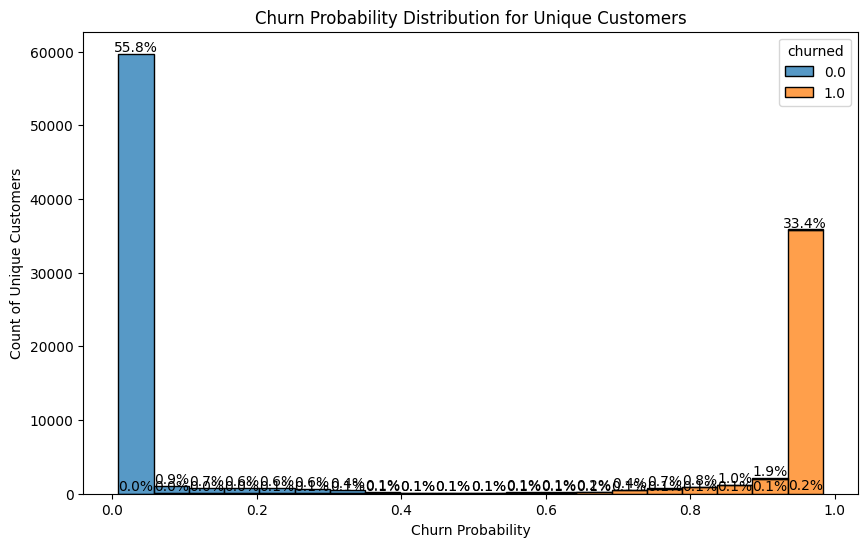

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

unique_customers_df = df.drop_duplicates(subset='client_id')

# Now, let's calculate the total number of unique customers
total_unique_customers = len(unique_customers_df)

# Create a histogram for the unique customers
plt.figure(figsize=(10, 6))
ax = sns.histplot(data=unique_customers_df, x='churn_probability', hue='churned', multiple='stack', bins=20)

# Annotate the bars with the percentage of unique customers in each category
for p in ax.patches:
    height = p.get_height()
    if height > 0:  
        # Calculate percentage as a proportion of the total number of unique customers
        percentage = f'{100 * height / total_unique_customers:.1f}%'
        # Get the center of each bar for the x-coordinate of the annotation
        x = p.get_x() + p.get_width() / 2
        # The y-coordinate is the height of the bar
        y = height
        # Annotate the percentage on the bar
        ax.annotate(percentage, (x, y), ha='center', va='bottom')

# Final adjustments before showing the plot
plt.title('Churn Probability Distribution for Unique Customers')
plt.xlabel('Churn Probability')
plt.ylabel('Count of Unique Customers')
plt.show()


In [ ]:
# function to categorize churn risk
def categorize_churn_risk(churn_probability):
    if churn_probability >= 0.6:
        return 'High Risk'
    else:
        return 'Low Risk'

# Applying the function
df['churn_risk_category'] = df['churn_probability'].apply(categorize_churn_risk)

# updated DataFrame
print(df.head())


   date_order  client_id   sales_net  quantity  product_price  \
0  2019-08-13          6   60.858000         3      20.286000   
1  2019-07-31          6   41.538000         3      13.846000   
2  2019-07-31          6   63.673200         3      21.224400   
3  2019-07-31          6  370.653924       401       0.924324   
4  2019-07-25          6   60.858000         3      20.286000   

   order_channel_at the store  order_channel_by phone  \
0                           0                       1   
1                           1                       0   
2                           1                       0   
3                           1                       0   
4                           0                       1   

   order_channel_during the visit of a sales rep  order_channel_online  \
0                                              0                     0   
1                                              0                     0   
2                                           

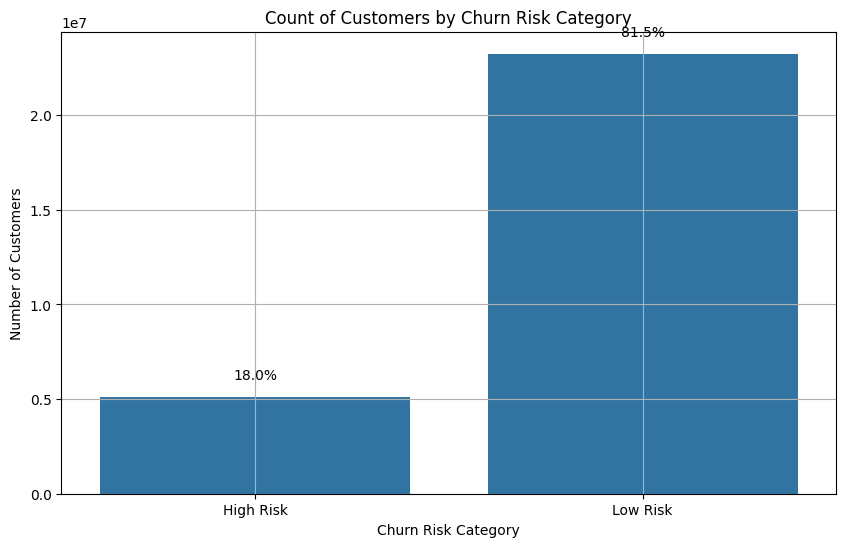

In [4]:
# Get counts for each churn risk category
churn_risk_counts = df['churn_risk_category'].value_counts()
total_customers = df.shape[0]

# Calculate the percentage of customers in each category
churn_risk_percentages = (churn_risk_counts / total_customers) * 100

# Plot the count of customers in each churn risk category
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='churn_risk_category', data=df, order=['High Risk','Low Risk'])
plt.title('Count of Customers by Churn Risk Category')
plt.xlabel('Churn Risk Category')
plt.ylabel('Number of Customers')
plt.grid(True)

# Annotate the bars with the percentage of customers in each category
for p in ax.patches:
    height = p.get_height()  # Get the height of each bar
    # Calculating the percentage as a proportion of total number of records in the data
    percentage = f'{100 * p.get_height() / total_customers:.1f}%'
    # Display the annotation above each bar
    ax.annotate(percentage, (p.get_x() + p.get_width() / 2.0, height),
                ha='center', va='bottom', xytext=(0, 10), textcoords='offset points')

plt.show()

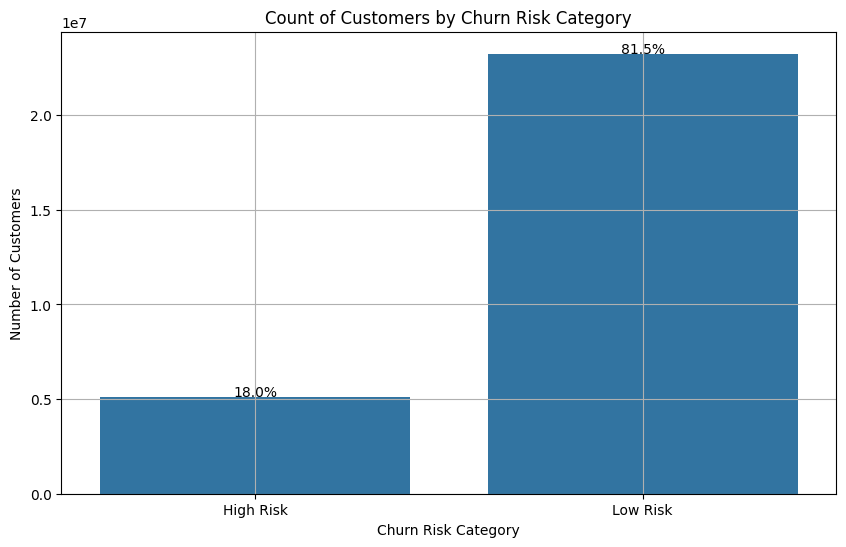

In [5]:
# Calculate the percentage of customers in each churn risk category
churn_risk_counts = df['churn_risk_category'].value_counts(normalize=True) * 100

# Create the plot
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='churn_risk_category', data=df, order=['High Risk','Low Risk'])
plt.title('Count of Customers by Churn Risk Category')
plt.xlabel('Churn Risk Category')
plt.ylabel('Number of Customers')
plt.grid(True)

# Annotate the bars with the percentage of customers in each category
for p in ax.patches:
    category = p.get_x() + p.get_width() / 2
    category_label = ax.get_xticklabels()[int(category)].get_text()
    percentage = churn_risk_counts[category_label]
    x = p.get_x() + p.get_width() / 2
    y = p.get_y() + p.get_height()
    ax.annotate(f'{percentage:.1f}%', (x, y), ha='center')

plt.show()

In [6]:
# Group by 'churn_risk_category' and sum the monetary values and potential revenue loss
category_summary = df.groupby('churn_risk_category').agg({
    'monetary': 'sum',
    'potential_revenue_loss': 'sum'
}).reset_index()

# Calculate the total potential revenue loss for percentage calculation
total_potential_loss = category_summary['potential_revenue_loss'].sum()

# Calculate the percentage of total potential loss per category
category_summary['percentage_of_total_loss'] = category_summary['potential_revenue_loss'] / total_potential_loss * 100

# Sort the categories for better visualization
category_summary = category_summary.sort_values('percentage_of_total_loss', ascending=False)

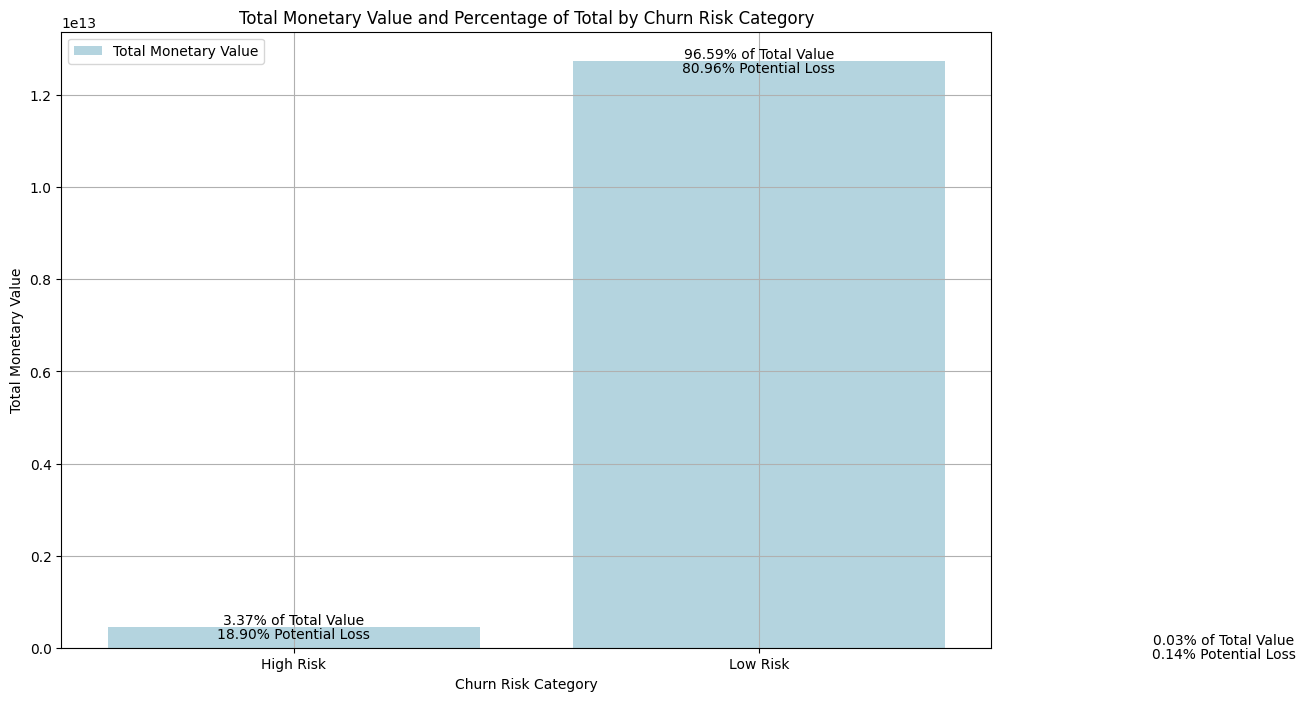

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort the category summary by churn risk category in the desired order
category_order = ['High Risk', 'Low Risk']
category_summary['churn_risk_category'] = pd.Categorical(category_summary['churn_risk_category'], categories=category_order, ordered=True)
category_summary = category_summary.sort_values('churn_risk_category')

# Plot the total monetary value by churn risk category
plt.figure(figsize=(12, 8))
monetary_bars = sns.barplot(x='churn_risk_category', y='monetary', data=category_summary, color='lightblue', label='Total Monetary Value')

# Calculate the total monetary value for the percentage calculation
total_monetary_value = category_summary['monetary'].sum()

# Annotate each bar with the percentage of total monetary contribution and the percentage of total potential loss
for index, row in category_summary.iterrows():
    # Calculate the percentage of the total monetary value
    monetary_percentage = (row['monetary'] / total_monetary_value) * 100
    # Annotate the monetary percentage
    plt.text(index, row['monetary'], f"{monetary_percentage:.2f}% of Total Value", color='black', ha="center", va="bottom")
    # Annotate the percentage of total potential loss
    plt.text(index, row['monetary'], f"{row['percentage_of_total_loss']:.2f}% Potential Loss", color='black', ha="center", va="top")

plt.title('Total Monetary Value and Percentage of Total by Churn Risk Category')
plt.xlabel('Churn Risk Category')
plt.ylabel('Total Monetary Value')
plt.legend()
plt.grid(True)
plt.show()


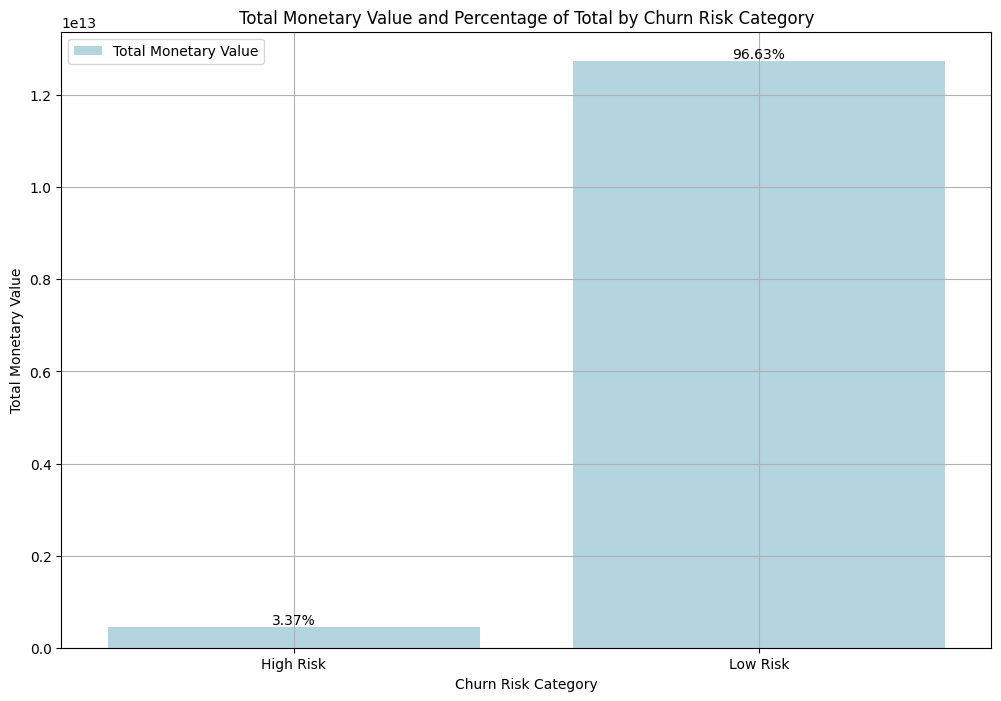

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort the category summary so that it's in the correct order for plotting
category_order = ['High Risk','Low Risk']
category_summary = category_summary.set_index('churn_risk_category').reindex(category_order).reset_index()

# Plot the total monetary value by churn risk category
plt.figure(figsize=(12, 8))
monetary_bars = sns.barplot(x='churn_risk_category', y='monetary', data=category_summary, order=category_order, color='lightblue', label='Total Monetary Value')

# Calculate the total monetary value for the percentage calculation
total_monetary_value = category_summary['monetary'].sum()

# Adding the percentage of total monetary contribution
for index, row in category_summary.iterrows():
    # Calculate the percentage of the total monetary value
    monetary_percentage = (row['monetary'] / total_monetary_value) * 100
    # Annotate the bar with this percentage
    plt.text(index, row['monetary'], f"{monetary_percentage:.2f}%", color='black', ha="center", va="bottom")

plt.title('Total Monetary Value and Percentage of Total by Churn Risk Category')
plt.xlabel('Churn Risk Category')
plt.ylabel('Total Monetary Value')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
# Calculate the average of churn probabilities for medium and high risk categories
average_churn_probability_high = df[df['churn_risk_category'].isin(['High Risk'])]['churn_probability'].mean()
average_churn_probability_high


0.965651231163861

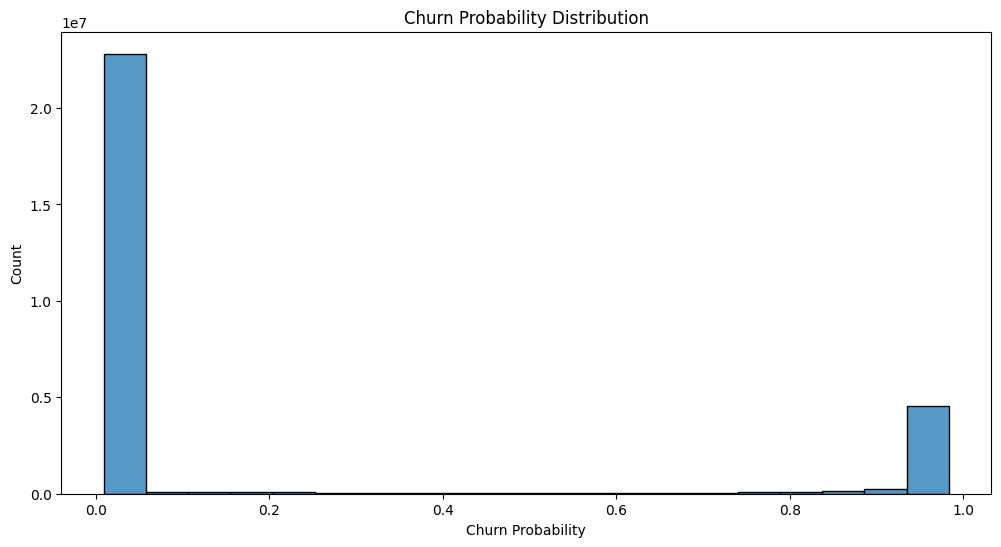

In [9]:
plt.figure(figsize=(12, 6))
sns.histplot(df['churn_probability'], bins=20)
plt.title('Churn Probability Distribution')
plt.xlabel('Churn Probability')
plt.ylabel('Count')
plt.show()



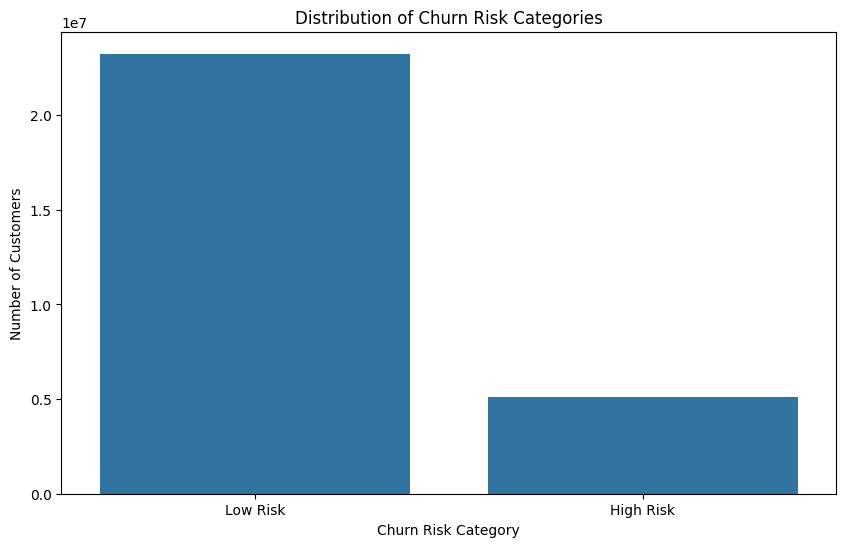

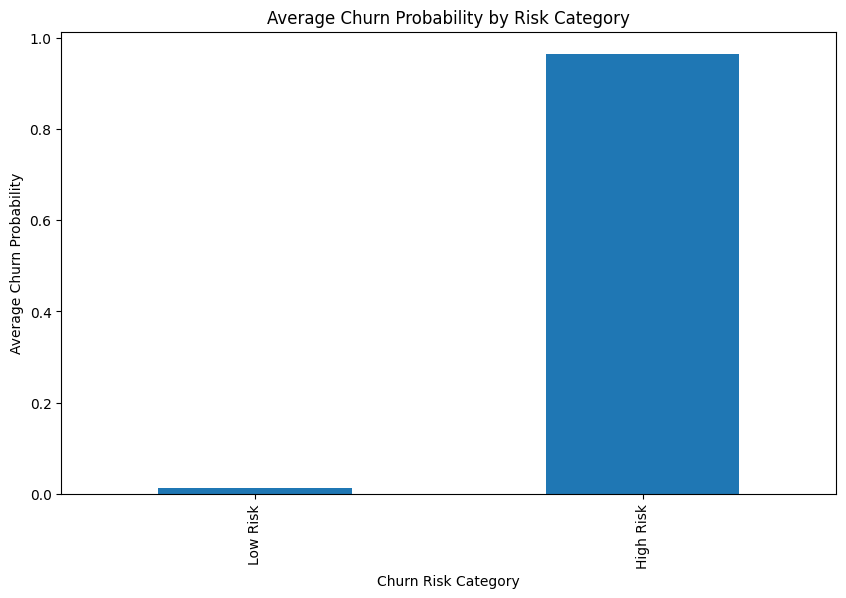

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd



# 1. Distribution of Churn Risk Categories
plt.figure(figsize=(10, 6))
sns.countplot(x='churn_risk_category', data=df, order=['Low Risk', 'High Risk'])
plt.title('Distribution of Churn Risk Categories')
plt.xlabel('Churn Risk Category')
plt.ylabel('Number of Customers')
plt.show()

# 2. Average Churn Probability by Category
avg_churn_prob = df.groupby('churn_risk_category')['churn_probability'].mean().reindex(['Low Risk', 'High Risk'])
plt.figure(figsize=(10, 6))
avg_churn_prob.plot(kind='bar')
plt.title('Average Churn Probability by Risk Category')
plt.xlabel('Churn Risk Category')
plt.ylabel('Average Churn Probability')
plt.show()

# 3. Potential Revenue Impact by Category (assuming you have a 'revenue' or 'CLV' column)
if 'revenue' in df.columns:
    df['potential_revenue_impact'] = df['churn_probability'] * df['revenue']
    revenue_impact = df.groupby('churn_risk_category')['potential_revenue_impact'].sum().reindex(['Low Risk', 'High Risk'])
    plt.figure(figsize=(10, 6))
    revenue_impact.plot(kind='bar', color='skyblue')
    plt.title('Potential Revenue Impact by Churn Risk Category')
    plt.xlabel('Churn Risk Category')
    plt.ylabel('Potential Revenue Impact')
    plt.show()
